# Goddard's Rocket Problem

### My project on Optimization and Optimal Control
#### Konrad Malik

## The most general problem statement:

This problem concerns controlling a rocket's thrust in such a way that it will archive the greatest height. There is no contraint on time and in the whole case just a one (vertical) direction is taken into consideration.

## Formal problem statement:
###### We assume that our equations of motion are nondimensionalized and normalized. That is they are not realistic but can be changed/transformed to such.

Take:
* $t$ - time
* $v(t)$ - velocity
* $h(t)$ - height
* $g(h)$ - gravitational acceleration
* $m(t)$ - mass
* $c$ - specific impulse
* $D(v,h)$ - drag
* $T(t)$ - thrust (our control)

Initial conditions:
* $h(0) = 1$
* $v(0) = 0$
* $m(0) = 1$

Boundary condition:
* $g(0) = 1$

Additional needed constants parameters, and formulas:
* $T_c = 3.5$
* $H_c = 500$
* $V_c = 620$
* $M_c = 0.6$
* $c = 0.5\sqrt{g(0)h(0)}$
* $D_c = 0.5 \frac{V_c m(0)}{g(0)}$
* $T_{max} = T_c g(0) m(0)$

Final condition (empty fuel tank):
* $m(t_f) = M_c m(0)$

As density and the gravitational constant are dependant on altitude, we will use simplified models for $D(v,h)$ and $g$:
* $D(v,h) = D_c v^2 exp(-H_c \frac{h-h(0)}{h(0)})$
* $g(h) = g(0) (\frac{h(0)}{h})^2$

Given the above, we can now define the rocket's equations of motion (EOM):

![Rocket](figures/1rocket.png)

\begin{align}
    \dot{h}(t) = & v(t) \\
    \dot{v}(t) = & \frac{1}{m(t)}[T(t)-D(v,h)] - g(h) \\
    \dot{m}(t) = & \frac{-T(t)}{c}
\end{align}

### We define our objective:
We will try to obtain the optimal thrust profile which will give us the highest altitude. That means we want to maximize $h(t_f)$ with no constraints on time $t_f$, thus we can write:
$$J(x,u) = -h(t_f) \tag{1}$$
where $x$ are our state variables: $[h,v,m]^T$, and $u$ is our control: $T(t)$.

The general formula for cost $J$ is:
$$J(x,u) = \phi(x(t_f)) + \int_{t_0}^{t_f} f(x(t),u(t)) dt$$
based on that we conclude:
$$\phi(x(t_f)) = -h(t_f) \tag{2}$$ 
$$f(x,u) = 0$$

#### Equations derivation
###### Hamiltonian

Given that Hamiltonian formula is:
$$H(x,u,\lambda) = L(x,u) + \lambda f(x,u)$$
in our case Hamiltonian equals:
$$H(x,u,\lambda) = \lambda_h + \lambda_v(\frac{1}{m(t)}[T(t)-D(v,h)] - g(h)) - \lambda_m \frac{T(t)}{c}$$

###### Co-state equations of motion

General formula:
$$\dot{\lambda} = - H_x$$
In our case:
\begin{align}
\dot{\lambda_h} = -H_h = & \lambda_v \frac{\partial D}{\partial h} \frac{1}{m} \\
\dot{\lambda_v} = -H_v = & -(\lambda_h - \lambda_v \frac{\partial D}{\partial v} \frac{1}{m}) = \lambda_v \frac{\partial D}{\partial v} \frac{1}{m} - \lambda_h \\
\dot{\lambda_m} = -H_m = & \frac{T-D}{m^2}
\end{align}

###### Co-state final conditions:
From (2) we have (as $\phi(x(t_f))$ a linear function of $h(t_f)$):
\begin{align}
&\lambda_h = -1 \\
&\lambda_h = 0 \\
&\lambda_h = 0
\end{align}

### Hamiltonian maximalization discussion:
The next step is to find when Hamiltonian achives its extrema based on the Pontryagin's Maximum Principle:
$$H(x,u,\lambda) = \lambda_h + \lambda_v(\frac{1}{m(t)}[T(t)-D(v,h)] - g(h)) - \lambda_m \frac{T(t)}{c}$$
grouping elemets in the above equation gives:
$$H(x,u,\lambda) = (\frac{\lambda_v}{m} - \frac{\lambda_m}{c})T - (\frac{D}{m} - g)\lambda_v + \lambda_h$$

As our control is $T$, it can be clearly seen that minimizing the above function can be achived in 3 different cases:
\begin{cases}
    \tag{3}
    T = T_{max},& \text{if } (\frac{\lambda_v}{m} - \frac{\lambda_m}{c}) < 0 \\
    0 < T < T_{max},& \text{if } (\frac{\lambda_v}{m} - \frac{\lambda_m}{c}) = 0 \\
    T = 0,              & \text{if} (\frac{\lambda_v}{m} - \frac{\lambda_m}{c}) > 0
\end{cases}

The middle expression corresponds to the so-called "singular arc". Singular arc typically occurs when Hamiltonian is linear in control (as in our case) and the coefficient of the control term equals zero (as in the middle expression).

On a singular arc the following must be staisfied:
$$H_T = \frac{\lambda_v}{m} - \frac{\lambda_m}{c} = 0$$
From that we conclude:
$$\dot{H}_T = \ddot{H}_T = 0$$

From the above equations a formula describing a nonlinear feedback control law for $T$ on a singular arc can be derived, however this is out of scope in this project.

Based on our above reasoning and papers such as *Drag-law Effects in the Goddard Problem* by Tsiotras and Kelley, a solution to the Goddard Problem as we defined it typically consists of a 3 arcs as defined in eq. (3).

## Numerical Solution
In order to solve out problem numerically we will use python 3.
Required packages:
OpenGoddard, numpy, matplotlib

Necessary imports:
- numpy: general scientific computing
- matplotlib: library for plotting
- OpenGoddard: library for solving optimization problems in python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
%matplotlib inline

We define a class "Rocket" with initial/boundary conditions as specified in our Formal Problem Statement.

Constants and paramterers are chosen based on OpenGoddard examples and can be freely changed.

Equations for drag coefficient, maximum thrust etc. were listed in "Formal Problem Statement" under "Additional needed constants parameters".

In [2]:
class Rocket:
    g0 = 1.0  # Gravity accel at surface

    def __init__(self):
        self.H0 = 1.0  # Initial height
        self.V0 = 0.0  # Initial velocity
        self.M0 = 1.0  # Initial mass
        self.Tc = 3.5  # Coeff of thrust
        self.Hc = 500  # Coeff of density changes
        self.Vc = 620  # Coeff of velocity
        self.Mc = 0.6  # Fraction of whole rocket mass reserved for fuel
        self.c = 0.5 * np.sqrt(self.g0*self.H0)  # Specific impulse (empirical formula)
        self.Mf = self.Mc * self.M0               # Final mass (empty rocket)
        self.Dc = 0.5 * self.Vc * self.M0 / self.g0  # Coeff of drag
        self.T_max = self.Tc * self.g0 * self.M0     # Maximum thrust (empirical formula)

We define the dynamics of our model.

Firstly the state variables $h$, $v$ and $m$ are assigned to the "Problem" class as "states". The "Problem" class in OpenGoddard is an abstraction representing the actual problem we want to solve. Thus, it is neccessary to provide state variables. 

Then, under the "control" comment, we are assigning control variables to the same Problem class. In this case the only control we have is thrust $T$.

Next, we take the necessary parameters from the defined earlier Rocket class.

In order to fully describe our dynamic equations, we need to define "additional formulas" for drag, which is dependent on the state variables, and gravity constant, which changes with altitude. 

In [3]:
def dynamics(prob, obj, section):
    # state
    h = prob.states(0, section) # height
    v = prob.states(1, section) # velocity
    m = prob.states(2, section) # mass
    # control
    T = prob.controls(0, section) # control (thrust)

    # Rocket class objects
    Dc = obj.Dc # drag coefficient as defined in Rocket class
    c = obj.c # specific impulse as defined in Rocket class
    g0 = obj.g0 # gravity constant as defined in Rocket class
    H0 = obj.H0 # initial height as defined in Rocket class
    Hc = obj.Hc # height constant as defined in Rocket class
    
    # additional formulas
    drag = Dc * v ** 2 * np.exp(-Hc * (h - H0) / H0) # drag equation
    g = g0 * (H0 / h)**2 # gravity constant 

    # final dynamic equations definition
    dx = Dynamics(prob, section)
    dx[0] = v
    dx[1] = (T - drag) / m - g
    dx[2] = - T / c
    return dx()

Define the equality constraints (initial and boundary conditions):

In [5]:
def equality(prob, obj):
    # state
    h = prob.states_all_section(0)
    v = prob.states_all_section(1)
    m = prob.states_all_section(2)
    # control
    T = prob.controls_all_section(0)
    # time
    tf = prob.time_final(-1)

    result = Condition()

    # conditions
    # initial
    result.equal(h[0], obj.H0)
    result.equal(v[0], obj.V0)
    result.equal(m[0], obj.M0)
    # end
    result.equal(v[-1], 0.0)
    result.equal(m[-1], obj.Mf)

    return result()

Define the inequality constraints:

In [6]:
def inequality(prob, obj):
    # retrieve state variables from the Problem class "prob"
    h = prob.states_all_section(0) # height
    v = prob.states_all_section(1) # velocity
    m = prob.states_all_section(2) # mass
    # retrieve control variables from the Problem class "prob"
    T = prob.controls_all_section(0) # thrust
    # retrieve time from the Problem class "prob"
    tf = prob.time_final(-1) # final time

    result = Condition()
    # lower bounds
    result.lower_bound(h, obj.H0)
    result.lower_bound(v, 0.0) # positive velocity
    result.lower_bound(m, obj.Mf) # mass cannot be lower than the final mass (empty rocket)
    result.lower_bound(T, 0.0) # positive thrust
    result.lower_bound(tf, 0.1) # assume that final time cannot be lower than 0.1 for stability
    # upper bounds
    result.upper_bound(m, obj.M0) # mass not larger than the initial mass
    result.upper_bound(T, obj.T_max) # thrust not larger than the maximal thrust

    return result()

Define the cost function as in eq. (1):

In [8]:
def cost(prob, obj):
    h = prob.states_all_section(0)
    return -h[-1] # final altitude

### Starting point (initialization)

In [12]:
time_init = [0.0, 0.5] # initial and final time (arbitrary value)
n = [100] # number of nodes
num_states = [3] # number of states
num_controls = [1] # number of controls
max_iteration = 40 # maximum number of iterations

Initialize OpenGoddard *Problem* class (main entry point to our optimization:

In [14]:
prob = Problem(time_init, n, num_states, num_controls, max_iteration)

Initialize a *Rocket* object:

In [16]:
obj = Rocket()

In order to be able to solve this optimization problem we need to initialze our state varables (make a initial guess about their profiles):

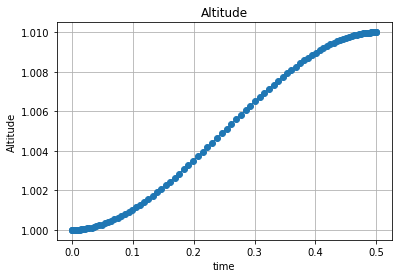

In [19]:
# altitude profile
H_init = Guess.cubic(prob.time_all_section, obj.H0, 0.0, 1.010, 0.0)
Guess.plot(prob.time_all_section, H_init, "Altitude", "time", "Altitude")

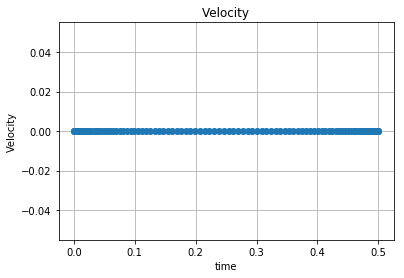

In [21]:
# velocity
V_init = Guess.linear(prob.time_all_section, 0.0, 0.0)
Guess.plot(prob.time_all_section, V_init, "Velocity", "time", "Velocity")

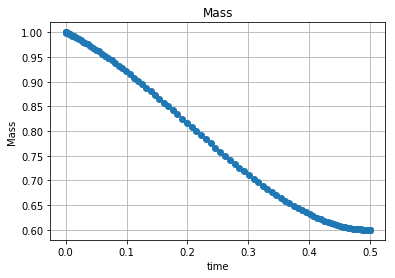

In [23]:
# mass profile
M_init = Guess.cubic(prob.time_all_section, obj.M0, -obj.Mc, obj.Mf, 0.0)
Guess.plot(prob.time_all_section, M_init, "Mass", "time", "Mass")

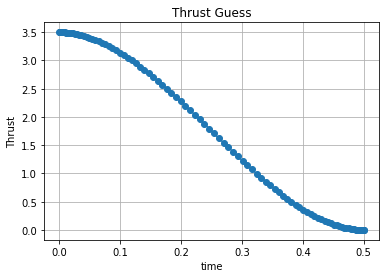

In [24]:
# thrust profile
T_init = Guess.cubic(prob.time_all_section, obj.Tc, 0.0, 0.0, 0.0)
Guess.plot(prob.time_all_section, T_init, "Thrust Guess", "time", "Thrust")

Set our initial guessess as the initial input to our problem:

In [25]:
prob.set_states_all_section(0, H_init)
prob.set_states_all_section(1, V_init)
prob.set_states_all_section(2, M_init)
prob.set_controls_all_section(0, T_init)

Set up our problem using the dynamics and constraints that we defined earlier:

In [27]:
prob.dynamics = [dynamics] # dynamics
prob.knot_states_smooth = [] # knot states (we are not using them)
prob.cost = cost # cost function
prob.cost_derivative = None # the derivative of the cost
prob.equality = equality # equality constraints
prob.inequality = inequality # inequality constraints

Set up a function used to display results during optimization process:

In [29]:
def display_func():
    h = prob.states_all_section(0)
    print("max altitude: {0:.5f}".format(h[-1]))

### Start the solver

In [31]:
prob.solve(obj, display_func, ftol=1e-10)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0080580256013836
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.00806

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0097000702717605
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.00970

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0107695800036205
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.01077

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0112605328863198
            Iterations: 26
            Function evaluati

Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0128295942527525
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.01283

---- iteration : 32 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0128299008217323
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.01283

---- iteration : 33 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1.0128299882354883
            Iterations: 26
            Function evaluations: 10478
            Gradient evaluations: 26
Iteration limit exceeded
max altitude: 1.01283

---- iteration : 34 ----
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.0128299883189094
            Iterations: 1
            Function evaluations: 404


We see that our optimisation ended after 34 iterations and that the maximal nondimensionalized altitude obtained was 1.01283.

### Post processing

Extract states, control and time from the solved case:

In [34]:
h = prob.states_all_section(0)
v = prob.states_all_section(1)
m = prob.states_all_section(2)
T = prob.controls_all_section(0)
time = prob.time_update()

Calculate necessary variables which cannot be explicitly extracted:

In [44]:
drag = obj.Dc * v ** 2 * np.exp(-obj.Hc * (h - 1.0) / 1.0)
g = obj.g0 * (obj.H0 / h)**2

### Results visualisation

Text(0,0.5,'Altitude [-]')

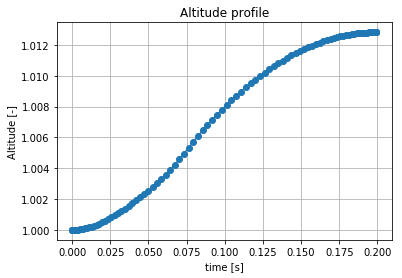

In [38]:
plt.figure()
plt.title("Altitude profile")
plt.plot(time, h, marker="o", label="Altitude")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Altitude [-]")

Text(0,0.5,'Velocity [-]')

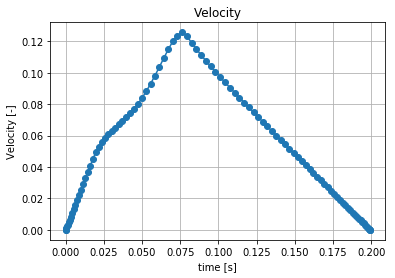

In [39]:
plt.figure()
plt.title("Velocity")
plt.plot(time, v, marker="o", label="Velocity")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Velocity [-]")

Text(0,0.5,'Mass [-]')

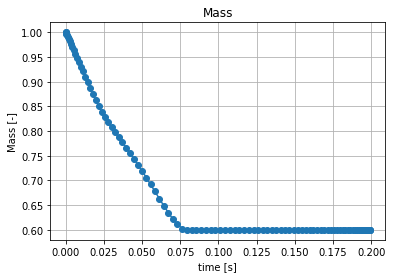

In [40]:
plt.figure()
plt.title("Mass")
plt.plot(time, m, marker="o", label="Mass")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Mass [-]")

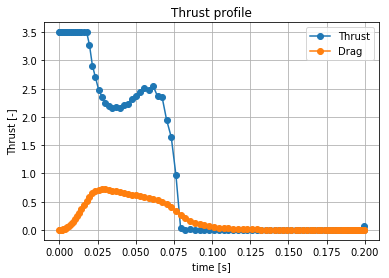

In [45]:
plt.figure()
plt.title("Thrust profile")
plt.plot(time, T, marker="o", label="Thrust")
plt.plot(time, drag, marker="o", label="Drag")
plt.grid()
plt.xlabel("time [s]")
plt.ylabel("Thrust [-]")
plt.legend(loc="best")

### Discussion

We can see that we accurately predicted that our solution should consist of 3 arcs. This scenario is called a *Bang-Singular-Bang scenario*. That is, we use maximum thrust initially to approx. t=0.02. Next, as in eq. (3), we are minimizing $H$, so we are keeping $\frac{\lambda_v}{m} - \frac{\lambda_m}{c} = 0$ until we ran out of fuel ($m(0)=m(t_f)$). Finally, we are forced to keep $T=0$ and wait until we reach the maximum altitude.

## References
Tsiotras P., Kelley H.J., *Drag-law Effects in the Goddard Problem*, 1991

*Principles of Optimal Control*, Course notes, MIT, 2008

*Nonlinear Systems and Control*, Course notes, Automatic Control Laboratory, ETH Zurich, 2015

*OpenGoddard* library examples